In [63]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

Importer des données

In [64]:

data=pd.read_csv("../laboratory.csv")

In [65]:
data.head()

TypPS  oxygen   pm10  cnt0_5     co  temperature  performance      co2  \
0  14.966  20.688  0.007   4.867  1.522       20.867        910.0  548.505   
1  14.996  20.687  0.001   3.496  1.521       20.865        915.0  543.500   
2  15.000  20.687  0.000   5.134  1.521       20.866        916.0  542.134   
3  14.081  20.688  0.213   4.223  1.521       20.864        918.0  539.314   
4  14.258  20.687  0.152   8.701  1.522       20.867        915.0  543.551   

   measuretime     so2  ...  health  temperature_o2 cnt2_5      o3  humidity  \
0         1876  38.461  ...   968.0          24.841  0.014  11.550    44.833   
1         1887  38.462  ...   942.0          24.845  0.002  11.520    44.784   
2         1858  38.463  ...   938.0          24.834  0.000  11.506    44.768   
3         1856  38.462  ...   936.0          24.834  0.618  11.438    44.766   
4         1862  38.462  ...   935.0          24.838  0.543  11.393    44.768   

   dHdt  humidity_abs   sound  pm2_5  cnt0_3  
0 -0.03         8.182  21.999    0.0  16.234  
1 -0.06         8.172  24.962    0.0  14.324  
2 -0.07         8.170  25.293    0.0  15.826  
3 -0.04         8.169  26.403    0.0  12.719  
4  0.00         8.170  25.934    0.0  26.107  

[5 rows x 31 columns]

In [66]:
data.tail()

TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
51181  2.257  20.906  4.770  227.998  1.530       24.533        798.0   
51182  1.920  20.906  4.169  229.625  1.529       24.546        782.0   
51183  1.688  20.907  5.038  228.146  1.529       24.572        772.0   
51184  1.515  20.905  5.092  246.341  1.530       24.590        761.0   
51185  1.225  20.907  4.216  229.139  1.532       24.614        758.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
51181  517.499         2046  176.872  ...   820.0          28.700  0.958   
51182  524.201         2088  177.372  ...   844.0          28.721  0.405   
51183  516.942         1827  173.799  ...   803.0          28.757  0.529   
51184  517.797         1828  167.632  ...   790.0          28.797  0.394   
51185  512.732         1999  162.133  ...   822.0          28.815  0.840   

           o3  humidity  dHdt  humidity_abs   sound  pm2_5   cnt0_3  
51181  28.679    39.472 -0.18         8.888  66.425  4.150  710.289  
51182  28.932    39.171 -0.30         8.826  65.066  3.800  725.006  
51183  29.264    38.641 -0.56         8.720  62.035  4.670  721.098  
51184  29.504    38.329 -0.63         8.658  65.898  4.789  780.604  
51185  29.658    38.106 -0.60         8.619  64.354  4.177  726.724  

[5 rows x 31 columns]

Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [67]:
print(data)

        TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      14.966  20.688  0.007    4.867  1.522       20.867        910.0   
1      14.996  20.687  0.001    3.496  1.521       20.865        915.0   
2      15.000  20.687  0.000    5.134  1.521       20.866        916.0   
3      14.081  20.688  0.213    4.223  1.521       20.864        918.0   
4      14.258  20.687  0.152    8.701  1.522       20.867        915.0   
...       ...     ...    ...      ...    ...          ...          ...   
51181   2.257  20.906  4.770  227.998  1.530       24.533        798.0   
51182   1.920  20.906  4.169  229.625  1.529       24.546        782.0   
51183   1.688  20.907  5.038  228.146  1.529       24.572        772.0   
51184   1.515  20.905  5.092  246.341  1.530       24.590        761.0   
51185   1.225  20.907  4.216  229.139  1.532       24.614        758.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      548.505         1876   38.46

**Nettoyage des données**

Supprimer les lignes nulles et les colonnes de caractéristiques inintéressantes

In [68]:

data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','humidity_abs','dHdt','cnt0_3'], axis=1, inplace=True)
data.dropna(inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])
# Certaines données sont manquantes, et je veux obtenir le plus de temps continu possible, je prendrai donc le paragraphe suivant
start_date = '2023-04-19'
end_date = '2023-06-03'
data = data[(data['timestamp'] >= start_date) & (data['timestamp'] <= end_date)]
# dates_to_remove = ['2023-04-17', '2023-05-21']
# dates_to_remove = pd.to_datetime(dates_to_remove)
# data = data[~data['timestamp'].dt.normalize().isin(dates_to_remove)]
# data = data[(data != 0).all(axis=1)]
columns = list(data.columns)
#Les paramètres « température », « pression », « humidité » existent pour les entrées,
# mais pas pour les sorties, ce qui facilite la transformation ultérieure des données
# en données d'apprentissage supervisé.  Il est plus facile de s'en occuper plus tard,
# sans avoir à se rappeler dans quelle colonne se trouvent les trois données.
columns.remove('temperature')
columns.remove('pressure')
columns.remove('humidity')
columns.extend(['temperature', 'pressure', 'humidity'])

data = data[columns]
print(data)

       oxygen    pm10     co      co2       so2     no2           timestamp  \
18440  20.789   9.315  1.735  507.934  2216.850  21.831 2023-04-19 11:39:01   
18441  20.790   9.040  1.730  504.029  2216.820  21.776 2023-04-19 11:41:03   
18442  20.789  10.338  1.726  503.302  2216.730  22.191 2023-04-19 11:43:05   
18443  20.793   9.173  1.723  503.272  2216.770  23.159 2023-04-19 11:45:06   
18444  20.792   8.218  1.720  503.708  2216.800  24.173 2023-04-19 11:47:08   
...       ...     ...    ...      ...       ...     ...                 ...   
49903  20.925   1.258  1.500  462.672   130.865  31.681 2023-06-02 23:51:16   
49904  20.925   1.608  1.500  460.642   130.676  31.438 2023-06-02 23:53:17   
49905  20.925   1.231  1.500  462.282   130.358  31.555 2023-06-02 23:55:18   
49906  20.924   1.321  1.500  460.177   129.813  31.540 2023-06-02 23:57:19   
49907  20.924   1.341  1.500  460.992   129.270  31.233 2023-06-02 23:59:20   

         pm1  dewpt     tvoc      o3   sound  pm2_5

Modifier le nom de timestamp et le convertir en index

In [69]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.head())

                     oxygen    pm10     co      co2      so2     no2    pm1  \
date                                                                          
2023-04-19 11:39:01  20.789   9.315  1.735  507.934  2216.85  21.831  6.452   
2023-04-19 11:41:03  20.790   9.040  1.730  504.029  2216.82  21.776  6.477   
2023-04-19 11:43:05  20.789  10.338  1.726  503.302  2216.73  22.191  6.661   
2023-04-19 11:45:06  20.793   9.173  1.723  503.272  2216.77  23.159  6.771   
2023-04-19 11:47:08  20.792   8.218  1.720  503.708  2216.80  24.173  5.844   

                     dewpt  tvoc      o3   sound  pm2_5  temperature  \
date                                                                   
2023-04-19 11:39:01  6.523   0.0  27.653  57.259  7.996       19.024   
2023-04-19 11:41:03  6.466   0.0  27.600  52.367  8.203       19.012   
2023-04-19 11:43:05  6.456   0.0  27.512  52.689  8.830       19.009   
2023-04-19 11:45:06  6.458   0.0  27.481  56.539  8.191       19.012   
2023-04-19 11:

Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

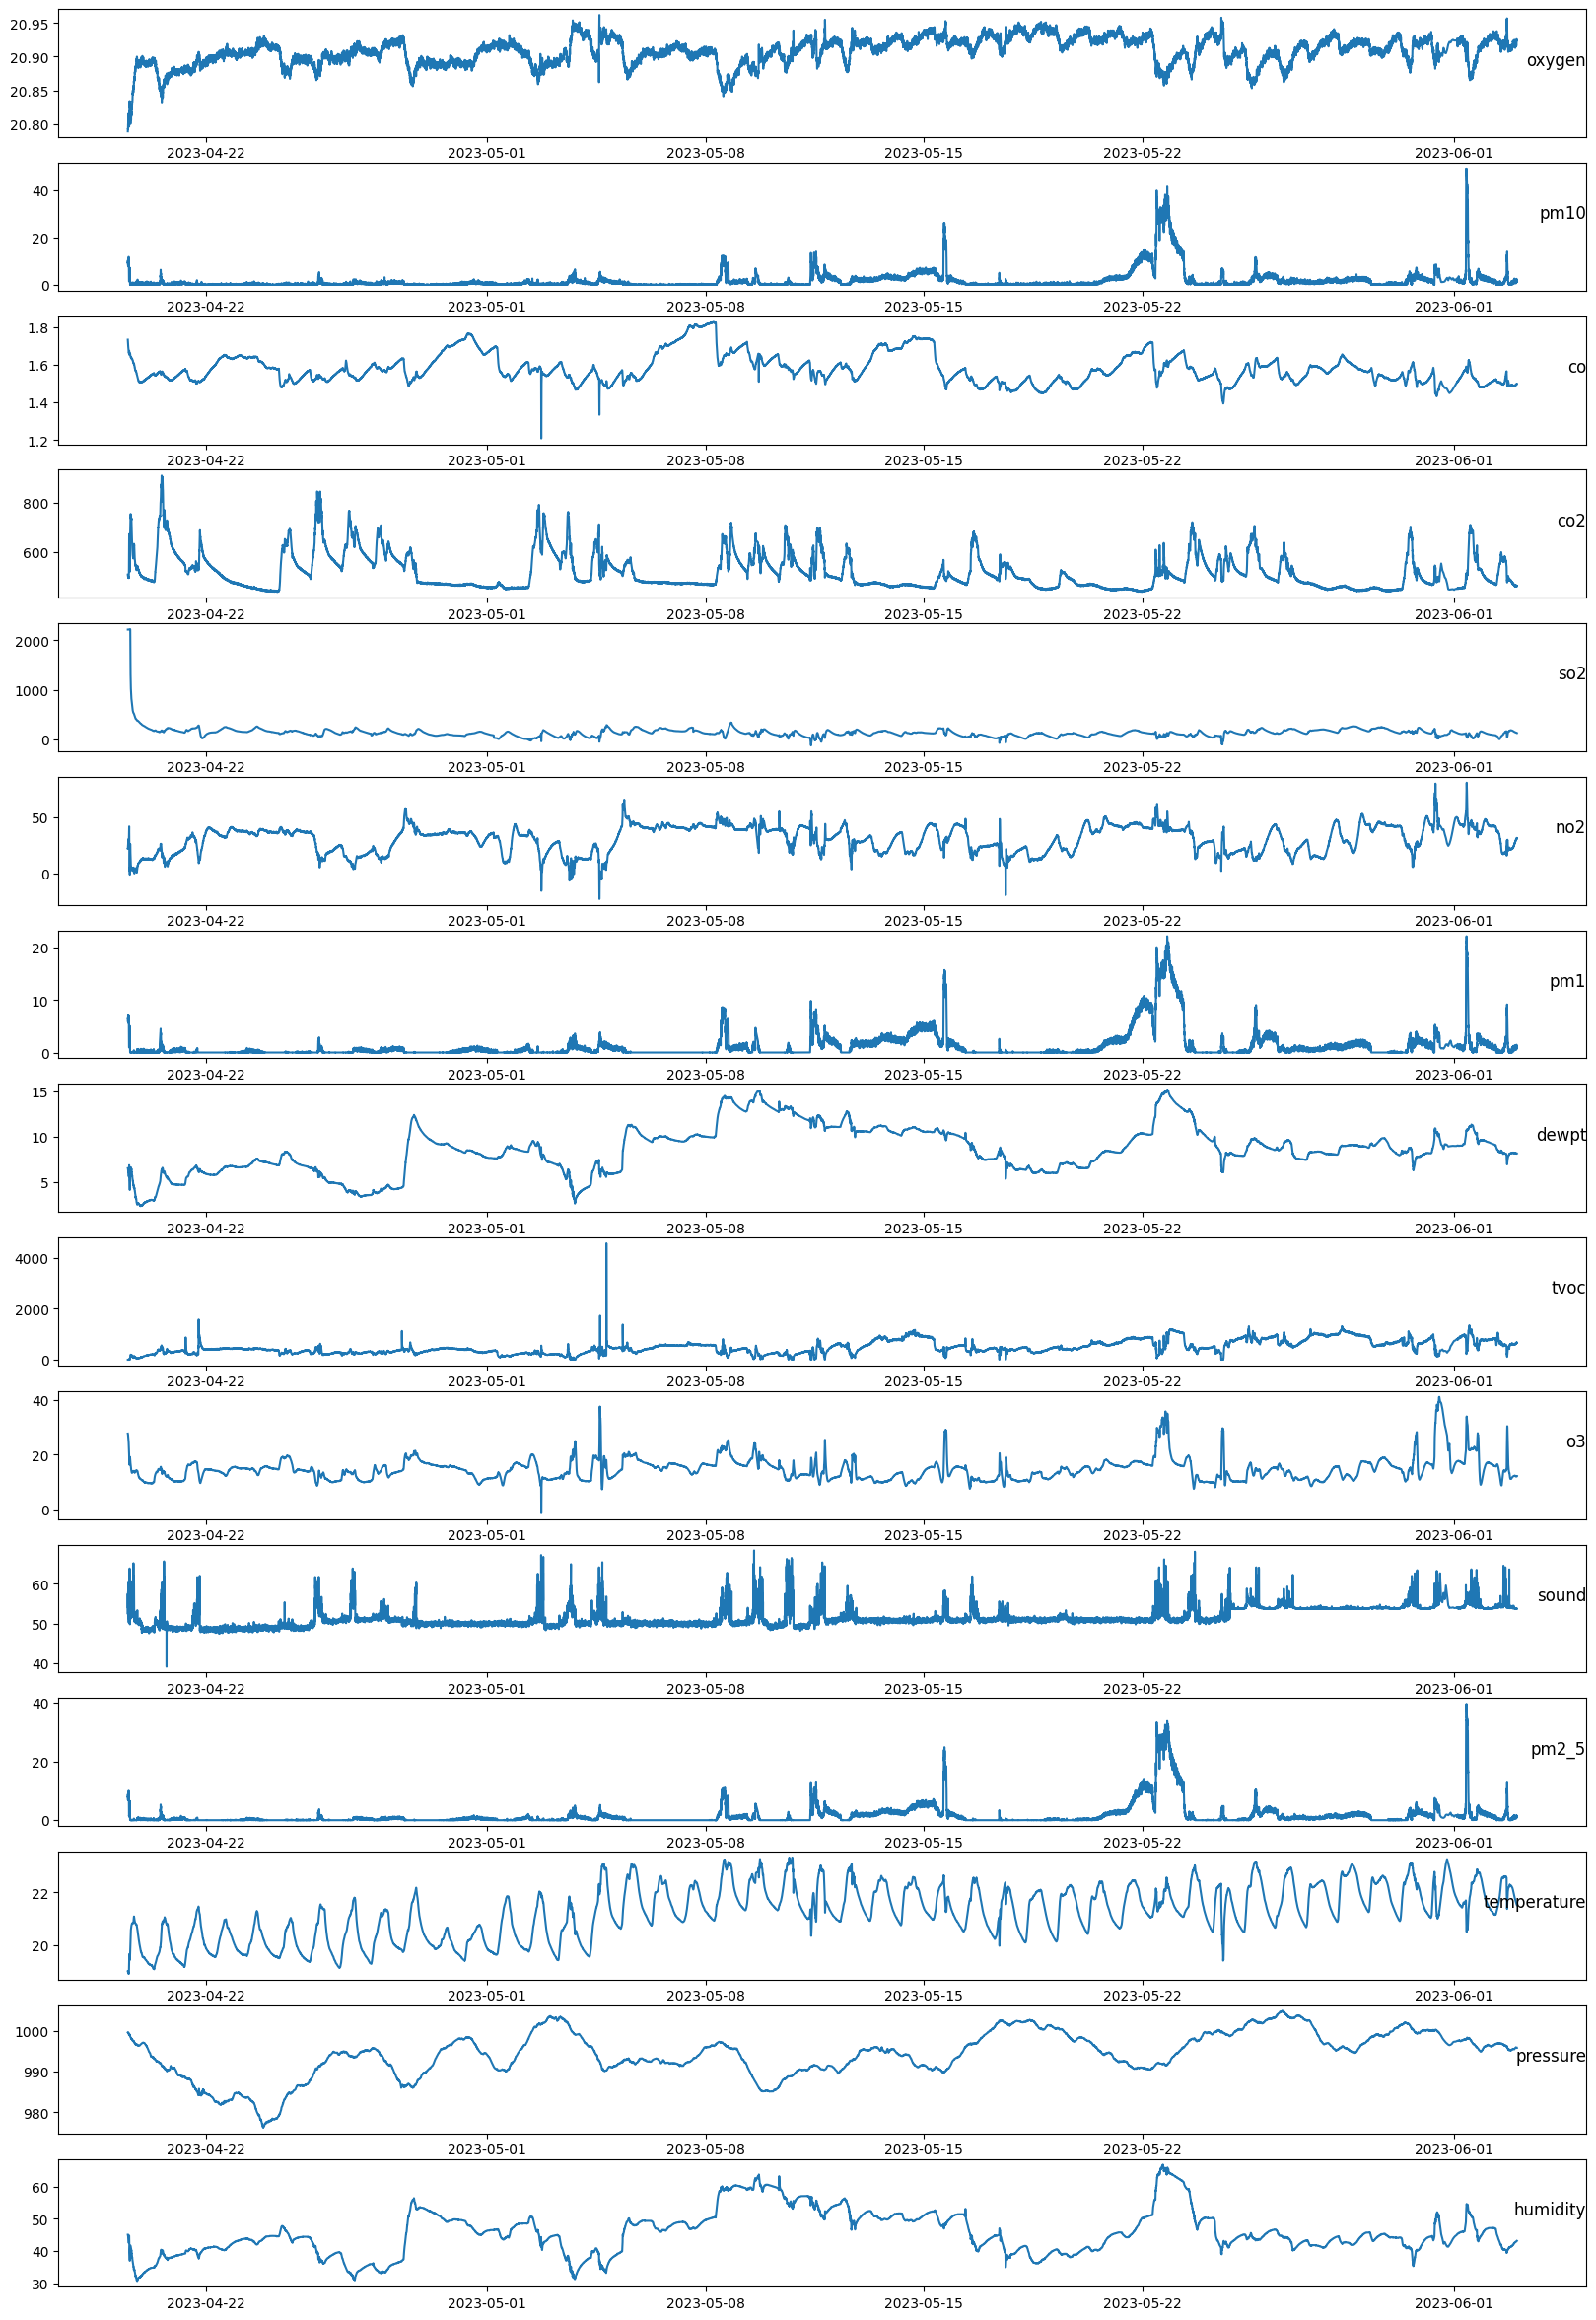

In [70]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9 ,10 ,11 ,12, 13, 14]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

**Multivariate LSTM Predictive Modeling**

In [71]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Les données de la série temporelle sont converties en données d'apprentissage supervisé et des étiquettes sont générées. Les variables d'entrée sont ensuite normalisées. Compte tenu des mesures de la pollution et des conditions météorologiques de l'heure précédente (t-1), nous posons le problème de l'apprentissage supervisé pour prédire la concentration de la pollution à l'heure actuelle (t).

In [72]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    agg = pd.concat(cols, axis=1)
    agg.columns = names


    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [73]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000000   0.189904   0.848387   0.149366   0.996458   0.431124   
2   0.005791   0.184298   0.840322   0.141075   0.996445   0.430600   
3   0.000000   0.210760   0.833871   0.139532   0.996406   0.434559   
4   0.023125   0.187009   0.829032   0.139468   0.996424   0.443796   
5   0.017342   0.167540   0.824193   0.140394   0.996436   0.453471   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...   var3(t)   var4(t)  \
1   0.290591   0.325957        0.0    0.684472  ...  0.840322  0.141075   
2   0.291717   0.321531        0.0    0.683219  ...  0.833871  0.139532   
3   0.300005   0.320755        0.0    0.681139  ...  0.829032  0.139468   
4   0.304959   0.320910        0.0    0.680407  ...  0.824193  0.140394   
5   0.263208   0.319124        0.0    0.677807  ...  0.817742  0.136453   

    var5(t)   var6(t)   var7(t)   var8(t)  var9(t)  var10(t)  var11(t)  \
1  0.996445  0.430600  0.291717  0.321531      0.0  0.683219  0.452520   
2  0.996406  0.434559  0.300005  0.320755      0.0  0.681139  0.463491   
3  0.996424  0.443796  0.304959  0.320910      0.0  0.680407  0.594671   
4  0.996436  0.453471  0.263208  0.319124      0.0  0.677807  0.628608   
5  0.996360  0.460178  0.288835  0.316950      0.0  0.675136  0.503492   

   var12(t)  
1  0.206875  
2  0.222687  
3  0.206572  
4  0.173711  
5  0.206244  

[5 rows x 27 columns]

Le pas de données est de 2 minutes, donc ici 1440 = 24*60, c'est-à-dire une prédiction des paramètres deux jours plus tard.

In [75]:
n_temps = 1440
n_features = 15

reframed = series_to_supervised(scaled, n_temps, 1)

In [76]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head(10)

var1(t-1440)  var2(t-1440)  var3(t-1440)  var4(t-1440)  var5(t-1440)  \
1440      0.000000      0.189904      0.848387      0.149366      0.996458   
1441      0.005791      0.184298      0.840322      0.141075      0.996445   
1442      0.000000      0.210760      0.833871      0.139532      0.996406   
1443      0.023125      0.187009      0.829032      0.139468      0.996424   
1444      0.017342      0.167540      0.824193      0.140394      0.996436   
1445      0.052032      0.179446      0.817742      0.136453      0.996360   
1446      0.052032      0.165583      0.809677      0.129000      0.996343   
1447      0.063583      0.197468      0.801613      0.128302      0.996262   
1448      0.057808      0.198426      0.795161      0.133763      0.996079   
1449      0.098267      0.184787      0.791935      0.125911      0.996032   

      var6(t-1440)  var7(t-1440)  var8(t-1440)  var9(t-1440)  var10(t-1440)  \
1440      0.431124      0.290591      0.325957           0.0       0.684472   
1441      0.430600      0.291717      0.321531           0.0       0.683219   
1442      0.434559      0.300005      0.320755           0.0       0.681139   
1443      0.443796      0.304959      0.320910           0.0       0.680407   
1444      0.453471      0.263208      0.319124           0.0       0.677807   
1445      0.460178      0.288835      0.316950           0.0       0.675136   
1446      0.468756      0.288925      0.314232           0.0       0.670976   
1447      0.474767      0.309373      0.309341           0.0       0.665280   
1448      0.475073      0.326217      0.304760           0.0       0.660529   
1449      0.475311      0.317209      0.303440           0.0       0.658497   

      ...   var3(t)   var4(t)   var5(t)   var6(t)   var7(t)   var8(t)  \
1440  ...  0.500000  0.200811  0.139095  0.543295  0.000000  0.302586   
1441  ...  0.501613  0.205701  0.139844  0.546806  0.000000  0.303207   
1442  ...  0.501613  0.204943  0.140383  0.549420  0.000000  0.304061   
1443  ...  0.500000  0.204206  0.140742  0.548342  0.000000  0.304527   
1444  ...  0.500000  0.204129  0.140886  0.546090  0.000000  0.306390   
1445  ...  0.501613  0.200637  0.141140  0.544554  0.000000  0.305769   
1446  ...  0.500000  0.201898  0.141533  0.540957  0.000540  0.306623   
1447  ...  0.500000  0.206556  0.141671  0.538448  0.000045  0.307477   
1448  ...  0.501613  0.207845  0.142326  0.537160  0.000000  0.307633   
1449  ...  0.501613  0.211306  0.142816  0.538467  0.000000  0.307555   

       var9(t)  var10(t)  var11(t)  var12(t)  
1440  0.046314  0.420208  0.328529  0.000000  
1441  0.046773  0.420161  0.334833  0.000000  
1442  0.047219  0.418601  0.333231  0.000000  
1443  0.047363  0.417845  0.337047  0.000000  
1444  0.047463  0.417230  0.345940  0.000000  
1445  0.049822  0.418364  0.336911  0.000000  
1446  0.047779  0.418695  0.323963  0.000303  
1447  0.047324  0.420468  0.328188  0.000025  
1448  0.046930  0.421957  0.314150  0.000000  
1449  0.047382  0.422406  0.332039  0.000000  

[10 rows x 21612 columns]

In [77]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows * 0.9)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_temps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(28321, 21600) (28321, 12) (1707, 21600) (1707, 12)


In [78]:
train_X = train_X.reshape((train_X.shape[0], n_temps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_temps, n_features))

print(test_X.shape,train_X.shape)

(1707, 1440, 15) (28321, 1440, 15)


In [79]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

# test3
# model = Sequential()
# model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(11))
# model.compile(optimizer='adam', loss='mae')
# model.summary()

# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dropout(0.5))
# model.add(LSTM(50))
# model.add(Dropout(0.5))
# model.add(Dense(11))
# model.compile(loss='mae', optimizer='adam')
# print(model.summary())

d:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        13,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,812 (53.95 KB)

 Trainable params: 13,812 (53.95 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/130
222/222 - 398s - 2s/step - loss: 0.1072 - val_loss: 0.0501
Epoch 2/130
222/222 - 410s - 2s/step - loss: 0.0724 - val_loss: 0.0452
Epoch 3/130
222/222 - 486s - 2s/step - loss: 0.0573 - val_loss: 0.0380
Epoch 4/130
222/222 - 414s - 2s/step - loss: 0.0490 - val_loss: 0.0348
Epoch 5/130
222/222 - 432s - 2s/step - loss: 0.0434 - val_loss: 0.0306
Epoch 6/130
222/222 - 458s - 2s/step - loss: 0.0399 - val_loss: 0.0303
Epoch 7/130
222/222 - 459s - 2s/step - loss: 0.0365 - val_loss: 0.0298
Epoch 8/130
222/222 - 440s - 2s/step - loss: 0.0343 - val_loss: 0.0274
Epoch 9/130
222/222 - 470s - 2s/step - loss: 0.0327 - val_loss: 0.0263
Epoch 10/130
222/222 - 476s - 2s/step - loss: 0.0318 - val_loss: 0.0273
Epoch 11/130
222/222 - 446s - 2s/step - loss: 0.0308 - val_loss: 0.0242
Epoch 12/130
222/222 - 436s - 2s/step - loss: 0.0295 - val_loss: 0.0244
Epoch 13/130
222/222 - 437s - 2s/step - loss: 0.0287 - val_loss: 0.0252
Epoch 14/130
222/222 - 450s - 2s/step - loss: 0.0286 - val_loss: 0.0245
E

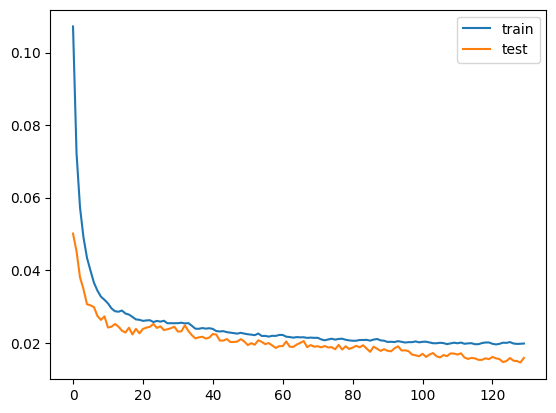

In [80]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[early_stopping])
history = model.fit(train_X, train_y, epochs=130, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# history = model.fit(train_X, train_y, epochs=200, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [81]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_temps*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [12, 13, 14]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns]

test_y = test_y.reshape(len(test_y), test_y.shape[1])
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())

54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step
          0      1      2           3           4          5      6      7   \
0  20.921000  2.475  1.506  479.887970  148.612000  48.271999  1.595  8.146   
1  20.923000  1.821  1.506  480.033997  148.227005  48.425999  1.291  8.151   
2  20.929001  2.565  1.506  478.789001  148.326004  48.632000  1.855  8.149   
3  20.929001  2.167  1.506  474.342010  148.130005  48.690002  1.599  8.143   
4  20.926001  2.737  1.506  475.026001  148.029999  48.692001  1.796  8.140   

           8          9          10     11  
0  717.888000  16.506001  53.962002  1.900  
1  705.403992  16.485001  53.779999  1.519  
2  704.439087  16.494999  53.749001  2.229  
3  710.427002  16.527998  53.685001  2.133  
4  701.901978  16.542997  53.720001  2.199  


In [82]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

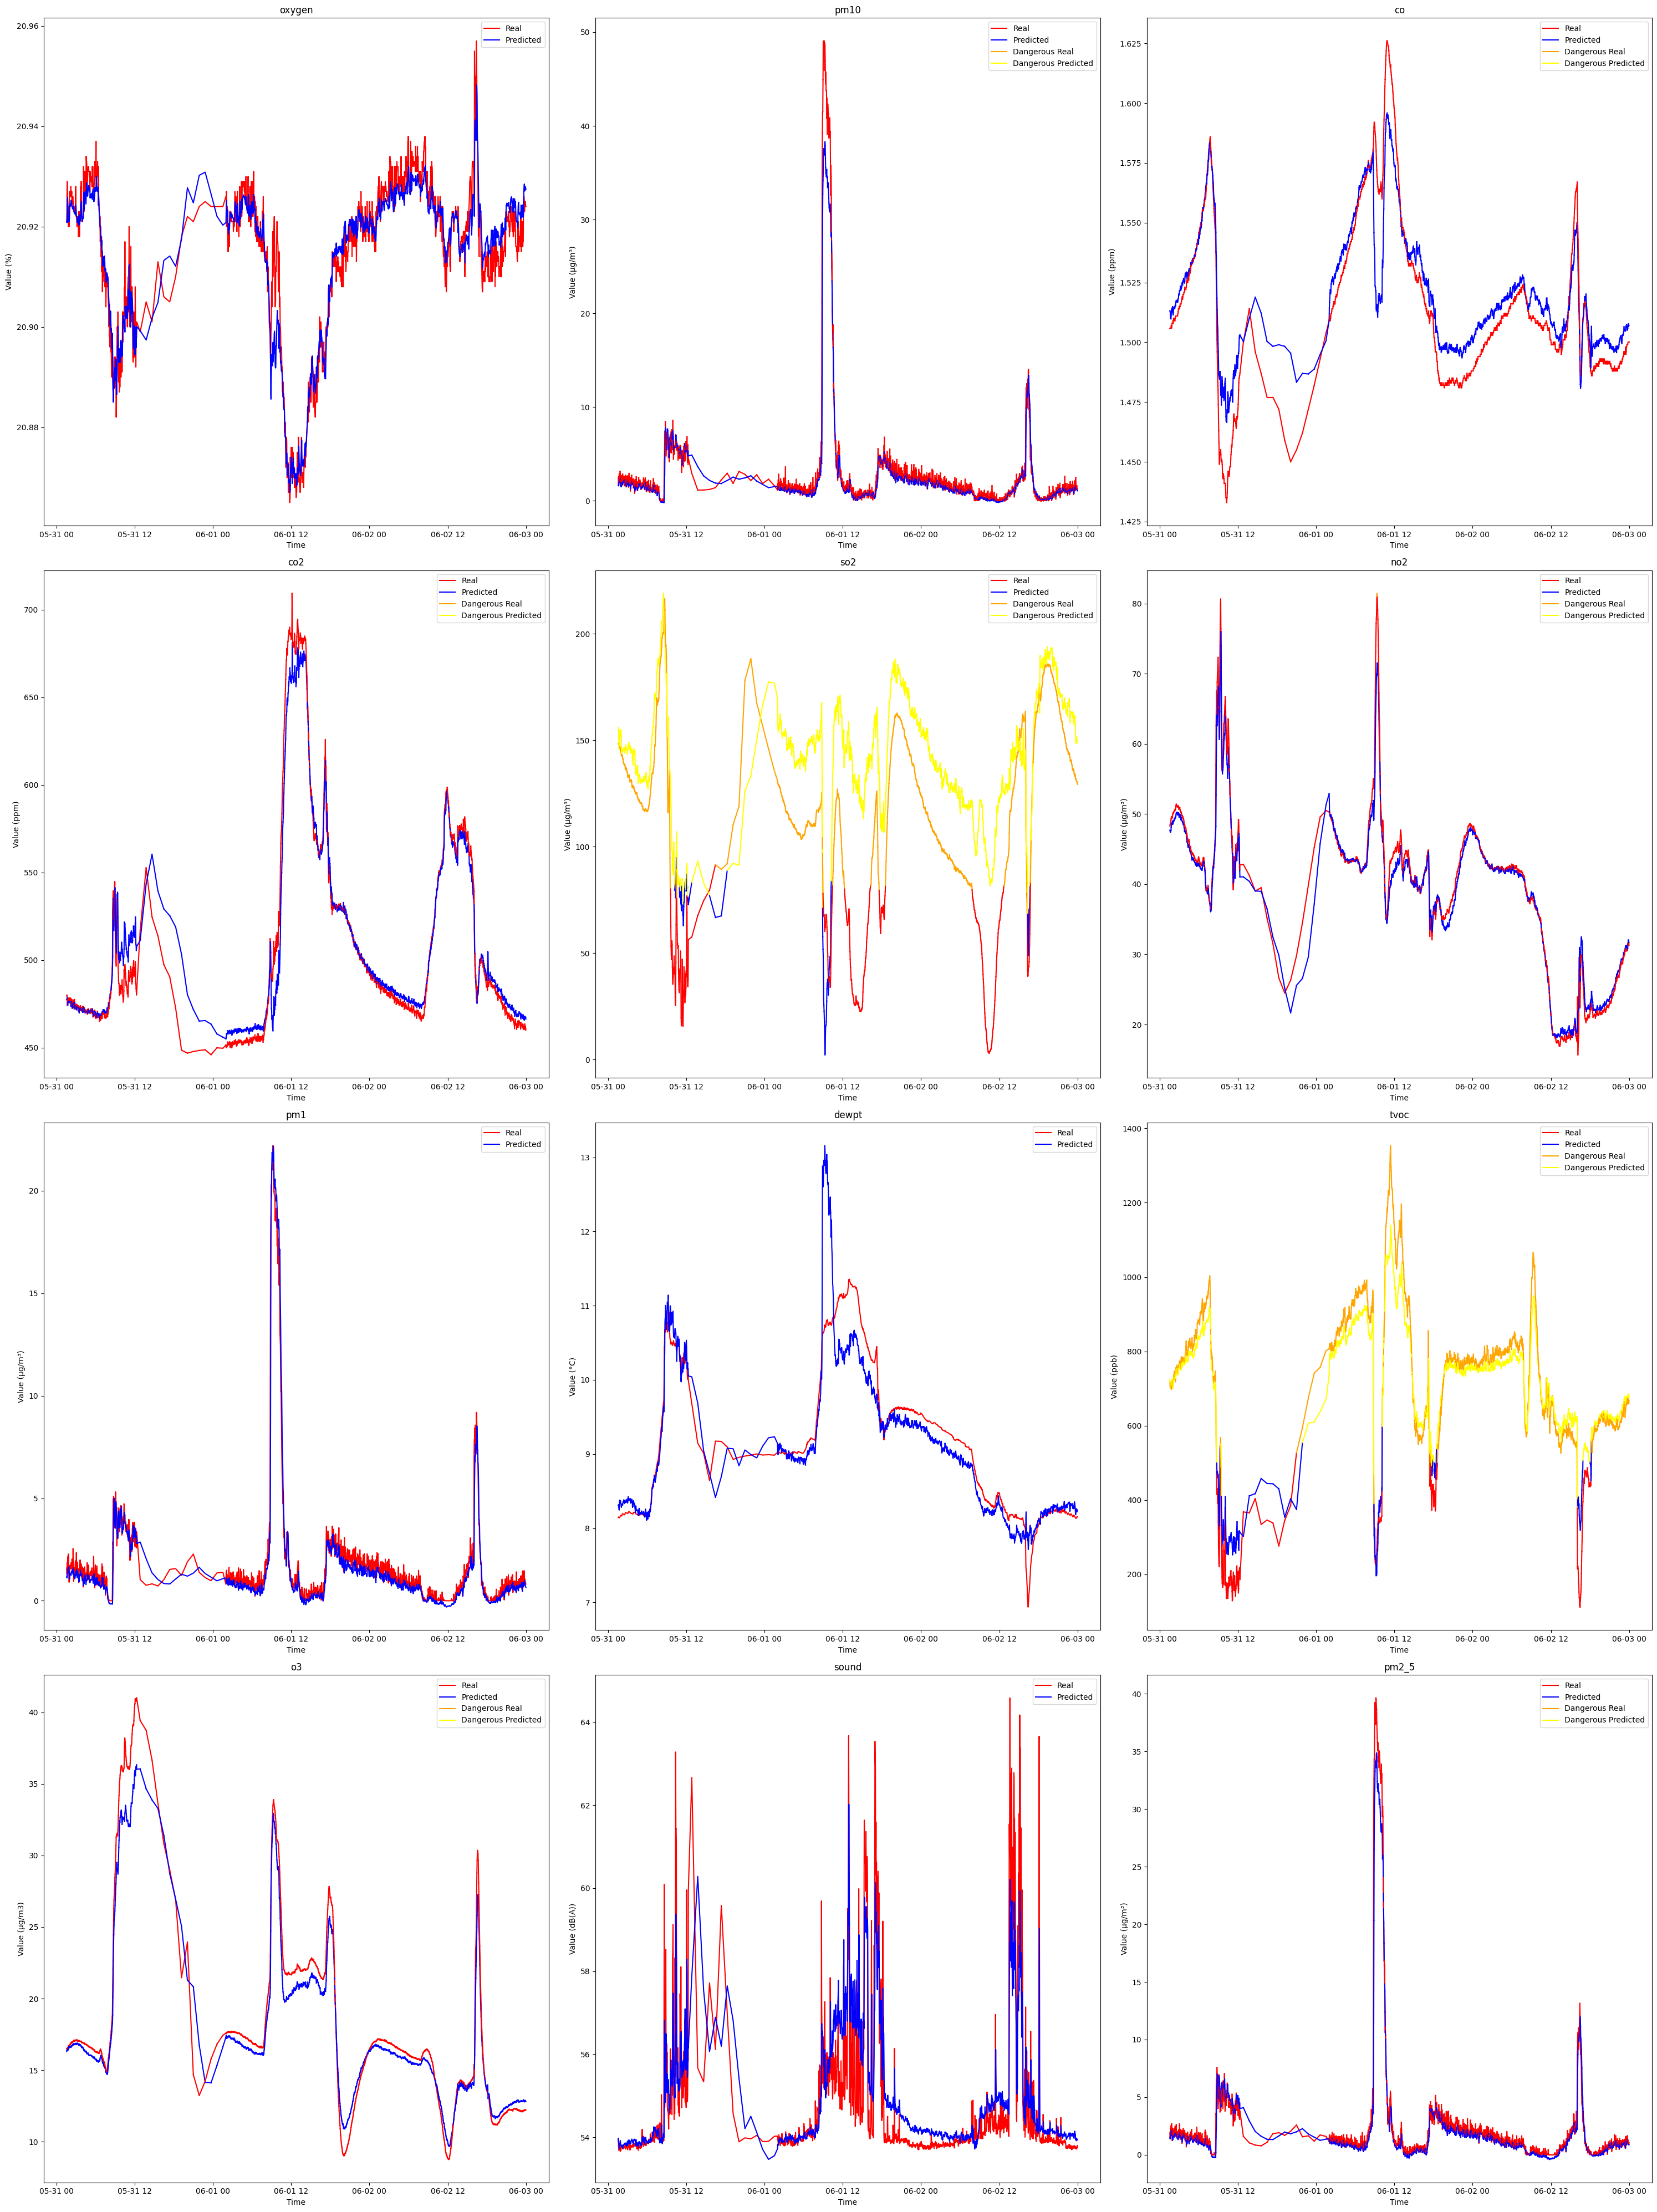

In [83]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'o3' : 9, 'sound': 10, 'pm2_5': 11
}

feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

In [84]:
selected_columns2 = [i for i in range(n_features) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
print(inv_y.shape, inv_yhat.shape)
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'o3', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

(1707, 12) (1707, 12)
Test RMSE for oxygen: 0.004
Test RMSE for pm10: 1.707
Test RMSE for co: 0.014
Test RMSE for co2: 10.168
Test RMSE for so2: 41.104
Test RMSE for no2: 1.649
Test RMSE for pm1: 0.619
Test RMSE for dewpt: 0.416
Test RMSE for tvoc: 63.069
Test RMSE for o3: 1.317
Test RMSE for sound: 1.006
Test RMSE for pm2_5: 1.101


In [85]:
# iaqi_condition_withouto3 = lambda x: (x[:, 6] <= 10) & (x[:, 11] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300)
# iaqi_condition = lambda x: (x[:, 6] <= 10) & (x[:, 10] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300) & (x[:, 9] < 18)
# inv_y_iaq = iaqi_condition_withouto3(inv_y).astype(int)
# inv_yhat_iaq = iaqi_condition_withouto3(inv_yhat).astype(int)
# inv_y_iaq2 = iaqi_condition(inv_y).astype(int)
# inv_yhat_iaq2 = iaqi_condition(inv_yhat).astype(int)

# inv_y = np.hstack((inv_y, inv_y_iaq.reshape(-1, 1)))
# inv_yhat = np.hstack((inv_yhat, inv_yhat_iaq.reshape(-1, 1)))
# inv_y2 = np.hstack((inv_y, inv_y_iaq2.reshape(-1, 1)))
# inv_yhat2 = np.hstack((inv_yhat, inv_yhat_iaq2.reshape(-1, 1)))

In [86]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 11]
inv_y_PM25_values = inv_y[:, 11]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

In [87]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 1]
inv_y_PM10_values = inv_y[:, 1]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

In [88]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 4]
inv_y_SO2_values = inv_y[:, 4]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

In [89]:
## NO2 Sub-Index calculation
def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 5]
inv_y_NO2_values = inv_y[:, 5]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in inv_yhat_NO2_values]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in inv_y_NO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

In [90]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 2]
inv_y_CO_values = inv_y[:, 2]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in inv_yhat_CO_values]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in inv_y_CO_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

In [91]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 9]
inv_y_O3_values = inv_y[:, 9]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

In [92]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 12
PM10_SubIndex_col = 13
SO2_SubIndex_col = 14
NO2_SubIndex_col = 15
CO_SubIndex_col = 16
O3_SubIndex_col = 17

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

        col0      col1      col2        col3        col4       col5      col6  \
0  20.921055  1.608087  1.513275  477.542816  155.974228  47.694538  1.119696   
1  20.920790  1.757967  1.512795  477.820007  155.192734  47.596649  1.216749   
2  20.921629  1.624957  1.512336  478.810455  153.342407  47.480915  1.120603   
3  20.924431  1.900246  1.510509  476.964905  147.734512  47.407478  1.309335   
4  20.925844  1.928083  1.509958  474.663544  145.691467  47.556976  1.335477   

       col7        col8       col9  ...     col11     col12     col13  \
0  8.304047  723.422424  16.297052  ...  1.392477  2.320795  1.608087   
1  8.316893  717.298035  16.390535  ...  1.525377  2.542295  1.757967   
2  8.282635  710.020569  16.369762  ...  1.402037  2.336728  1.624957   
3  8.255298  701.694885  16.425554  ...  1.652594  2.754323  1.900246   
4  8.243653  706.467407  16.375147  ...  1.683427  2.805711  1.928083   

        col14      col15      col16      col17  AQI_calculated  Checks  \


In [93]:
rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
print("RMSE: " + str(rmse))

RMSE: 1.1014255974417546


In [94]:

from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.9121265377855887


In [95]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 

1557.0


**Multivariate RNN Predictive Modeling**

In [43]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000000   0.189904   0.848387   0.149366   0.996458   0.431124   
2   0.005791   0.184298   0.840322   0.141075   0.996445   0.430600   
3   0.000000   0.210760   0.833871   0.139532   0.996406   0.434559   
4   0.023125   0.187009   0.829032   0.139468   0.996424   0.443796   
5   0.017342   0.167540   0.824193   0.140394   0.996436   0.453471   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...   var3(t)   var4(t)  \
1   0.290591   0.325957        0.0    0.684472  ...  0.840322  0.141075   
2   0.291717   0.321531        0.0    0.683219  ...  0.833871  0.139532   
3   0.300005   0.320755        0.0    0.681139  ...  0.829032  0.139468   
4   0.304959   0.320910        0.0    0.680407  ...  0.824193  0.140394   
5   0.263208   0.319124        0.0    0.677807  ...  0.817742  0.136453   

    var5(t)   var6(t)   var7(t)   var8(t)  var9(t)  var10(t)  var11(t)  \
1  0.996445  0.430600  0.291717  0.321531      0.0  0.683219  0.452520   
2  0.996406  0.434559  0.300005  0.320755      0.0  0.681139  0.463491   
3  0.996424  0.443796  0.304959  0.320910      0.0  0.680407  0.594671   
4  0.996436  0.453471  0.263208  0.319124      0.0  0.677807  0.628608   
5  0.996360  0.460178  0.288835  0.316950      0.0  0.675136  0.503492   

   var12(t)  
1  0.206875  
2  0.222687  
3  0.206572  
4  0.173711  
5  0.206244  

[5 rows x 27 columns]

In [44]:
n_temps = 1440
n_features = 15

reframed = series_to_supervised(scaled, n_temps, 1)

In [45]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head(10)

var1(t-1440)  var2(t-1440)  var3(t-1440)  var4(t-1440)  var5(t-1440)  \
1440      0.000000      0.189904      0.848387      0.149366      0.996458   
1441      0.005791      0.184298      0.840322      0.141075      0.996445   
1442      0.000000      0.210760      0.833871      0.139532      0.996406   
1443      0.023125      0.187009      0.829032      0.139468      0.996424   
1444      0.017342      0.167540      0.824193      0.140394      0.996436   
1445      0.052032      0.179446      0.817742      0.136453      0.996360   
1446      0.052032      0.165583      0.809677      0.129000      0.996343   
1447      0.063583      0.197468      0.801613      0.128302      0.996262   
1448      0.057808      0.198426      0.795161      0.133763      0.996079   
1449      0.098267      0.184787      0.791935      0.125911      0.996032   

      var6(t-1440)  var7(t-1440)  var8(t-1440)  var9(t-1440)  var10(t-1440)  \
1440      0.431124      0.290591      0.325957           0.0       0.684472   
1441      0.430600      0.291717      0.321531           0.0       0.683219   
1442      0.434559      0.300005      0.320755           0.0       0.681139   
1443      0.443796      0.304959      0.320910           0.0       0.680407   
1444      0.453471      0.263208      0.319124           0.0       0.677807   
1445      0.460178      0.288835      0.316950           0.0       0.675136   
1446      0.468756      0.288925      0.314232           0.0       0.670976   
1447      0.474767      0.309373      0.309341           0.0       0.665280   
1448      0.475073      0.326217      0.304760           0.0       0.660529   
1449      0.475311      0.317209      0.303440           0.0       0.658497   

      ...   var3(t)   var4(t)   var5(t)   var6(t)   var7(t)   var8(t)  \
1440  ...  0.500000  0.200811  0.139095  0.543295  0.000000  0.302586   
1441  ...  0.501613  0.205701  0.139844  0.546806  0.000000  0.303207   
1442  ...  0.501613  0.204943  0.140383  0.549420  0.000000  0.304061   
1443  ...  0.500000  0.204206  0.140742  0.548342  0.000000  0.304527   
1444  ...  0.500000  0.204129  0.140886  0.546090  0.000000  0.306390   
1445  ...  0.501613  0.200637  0.141140  0.544554  0.000000  0.305769   
1446  ...  0.500000  0.201898  0.141533  0.540957  0.000540  0.306623   
1447  ...  0.500000  0.206556  0.141671  0.538448  0.000045  0.307477   
1448  ...  0.501613  0.207845  0.142326  0.537160  0.000000  0.307633   
1449  ...  0.501613  0.211306  0.142816  0.538467  0.000000  0.307555   

       var9(t)  var10(t)  var11(t)  var12(t)  
1440  0.046314  0.420208  0.328529  0.000000  
1441  0.046773  0.420161  0.334833  0.000000  
1442  0.047219  0.418601  0.333231  0.000000  
1443  0.047363  0.417845  0.337047  0.000000  
1444  0.047463  0.417230  0.345940  0.000000  
1445  0.049822  0.418364  0.336911  0.000000  
1446  0.047779  0.418695  0.323963  0.000303  
1447  0.047324  0.420468  0.328188  0.000025  
1448  0.046930  0.421957  0.314150  0.000000  
1449  0.047382  0.422406  0.332039  0.000000  

[10 rows x 21612 columns]

In [46]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows * 0.9)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_temps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(28321, 21600) (28321, 12) (1707, 21600) (1707, 12)


In [47]:
train_X = train_X.reshape((train_X.shape[0], n_temps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_temps, n_features))

print(test_X.shape,train_X.shape)

(1707, 1440, 15) (28321, 1440, 15)


In [48]:
model = Sequential()
model.add(SimpleRNN(units = 50, activation='tanh', input_shape= (train_X.shape[1],train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(units = 12))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

d:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,912 (15.28 KB)

 Trainable params: 3,912 (15.28 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/100
222/222 - 41s - 185ms/step - loss: 0.1577 - val_loss: 0.0588
Epoch 2/100
222/222 - 35s - 160ms/step - loss: 0.0802 - val_loss: 0.0393
Epoch 3/100
222/222 - 35s - 158ms/step - loss: 0.0611 - val_loss: 0.0357
Epoch 4/100
222/222 - 36s - 160ms/step - loss: 0.0501 - val_loss: 0.0328
Epoch 5/100
222/222 - 36s - 164ms/step - loss: 0.0429 - val_loss: 0.0285
Epoch 6/100
222/222 - 36s - 164ms/step - loss: 0.0385 - val_loss: 0.0266
Epoch 7/100
222/222 - 38s - 173ms/step - loss: 0.0351 - val_loss: 0.0245
Epoch 8/100
222/222 - 39s - 176ms/step - loss: 0.0329 - val_loss: 0.0245
Epoch 9/100
222/222 - 39s - 174ms/step - loss: 0.0305 - val_loss: 0.0216
Epoch 10/100
222/222 - 39s - 174ms/step - loss: 0.0288 - val_loss: 0.0211
Epoch 11/100
222/222 - 38s - 173ms/step - loss: 0.0288 - val_loss: 0.0232
Epoch 12/100
222/222 - 38s - 171ms/step - loss: 0.0293 - val_loss: 0.0231
Epoch 13/100
222/222 - 38s - 173ms/step - loss: 0.0291 - val_loss: 0.0254
Epoch 14/100
222/222 - 38s - 172ms/step - loss:

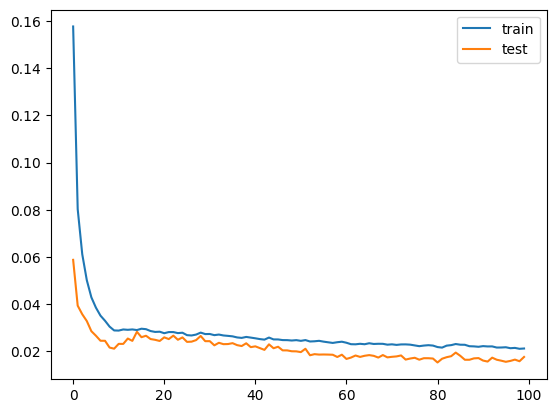

In [49]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[early_stopping])
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [50]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_temps*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [12, 13, 14]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns]

test_y = test_y.reshape(len(test_y), test_y.shape[1])
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step
          0      1      2           3           4          5      6      7   \
0  20.921000  2.475  1.506  479.887970  148.612000  48.271999  1.595  8.146   
1  20.923000  1.821  1.506  480.033997  148.227005  48.425999  1.291  8.151   
2  20.929001  2.565  1.506  478.789001  148.326004  48.632000  1.855  8.149   
3  20.929001  2.167  1.506  474.342010  148.130005  48.690002  1.599  8.143   
4  20.926001  2.737  1.506  475.026001  148.029999  48.692001  1.796  8.140   

           8          9          10     11  
0  717.888000  16.506001  53.962002  1.900  
1  705.403992  16.485001  53.779999  1.519  
2  704.439087  16.494999  53.749001  2.229  
3  710.427002  16.527998  53.685001  2.133  
4  701.901978  16.542997  53.720001  2.199  


In [51]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

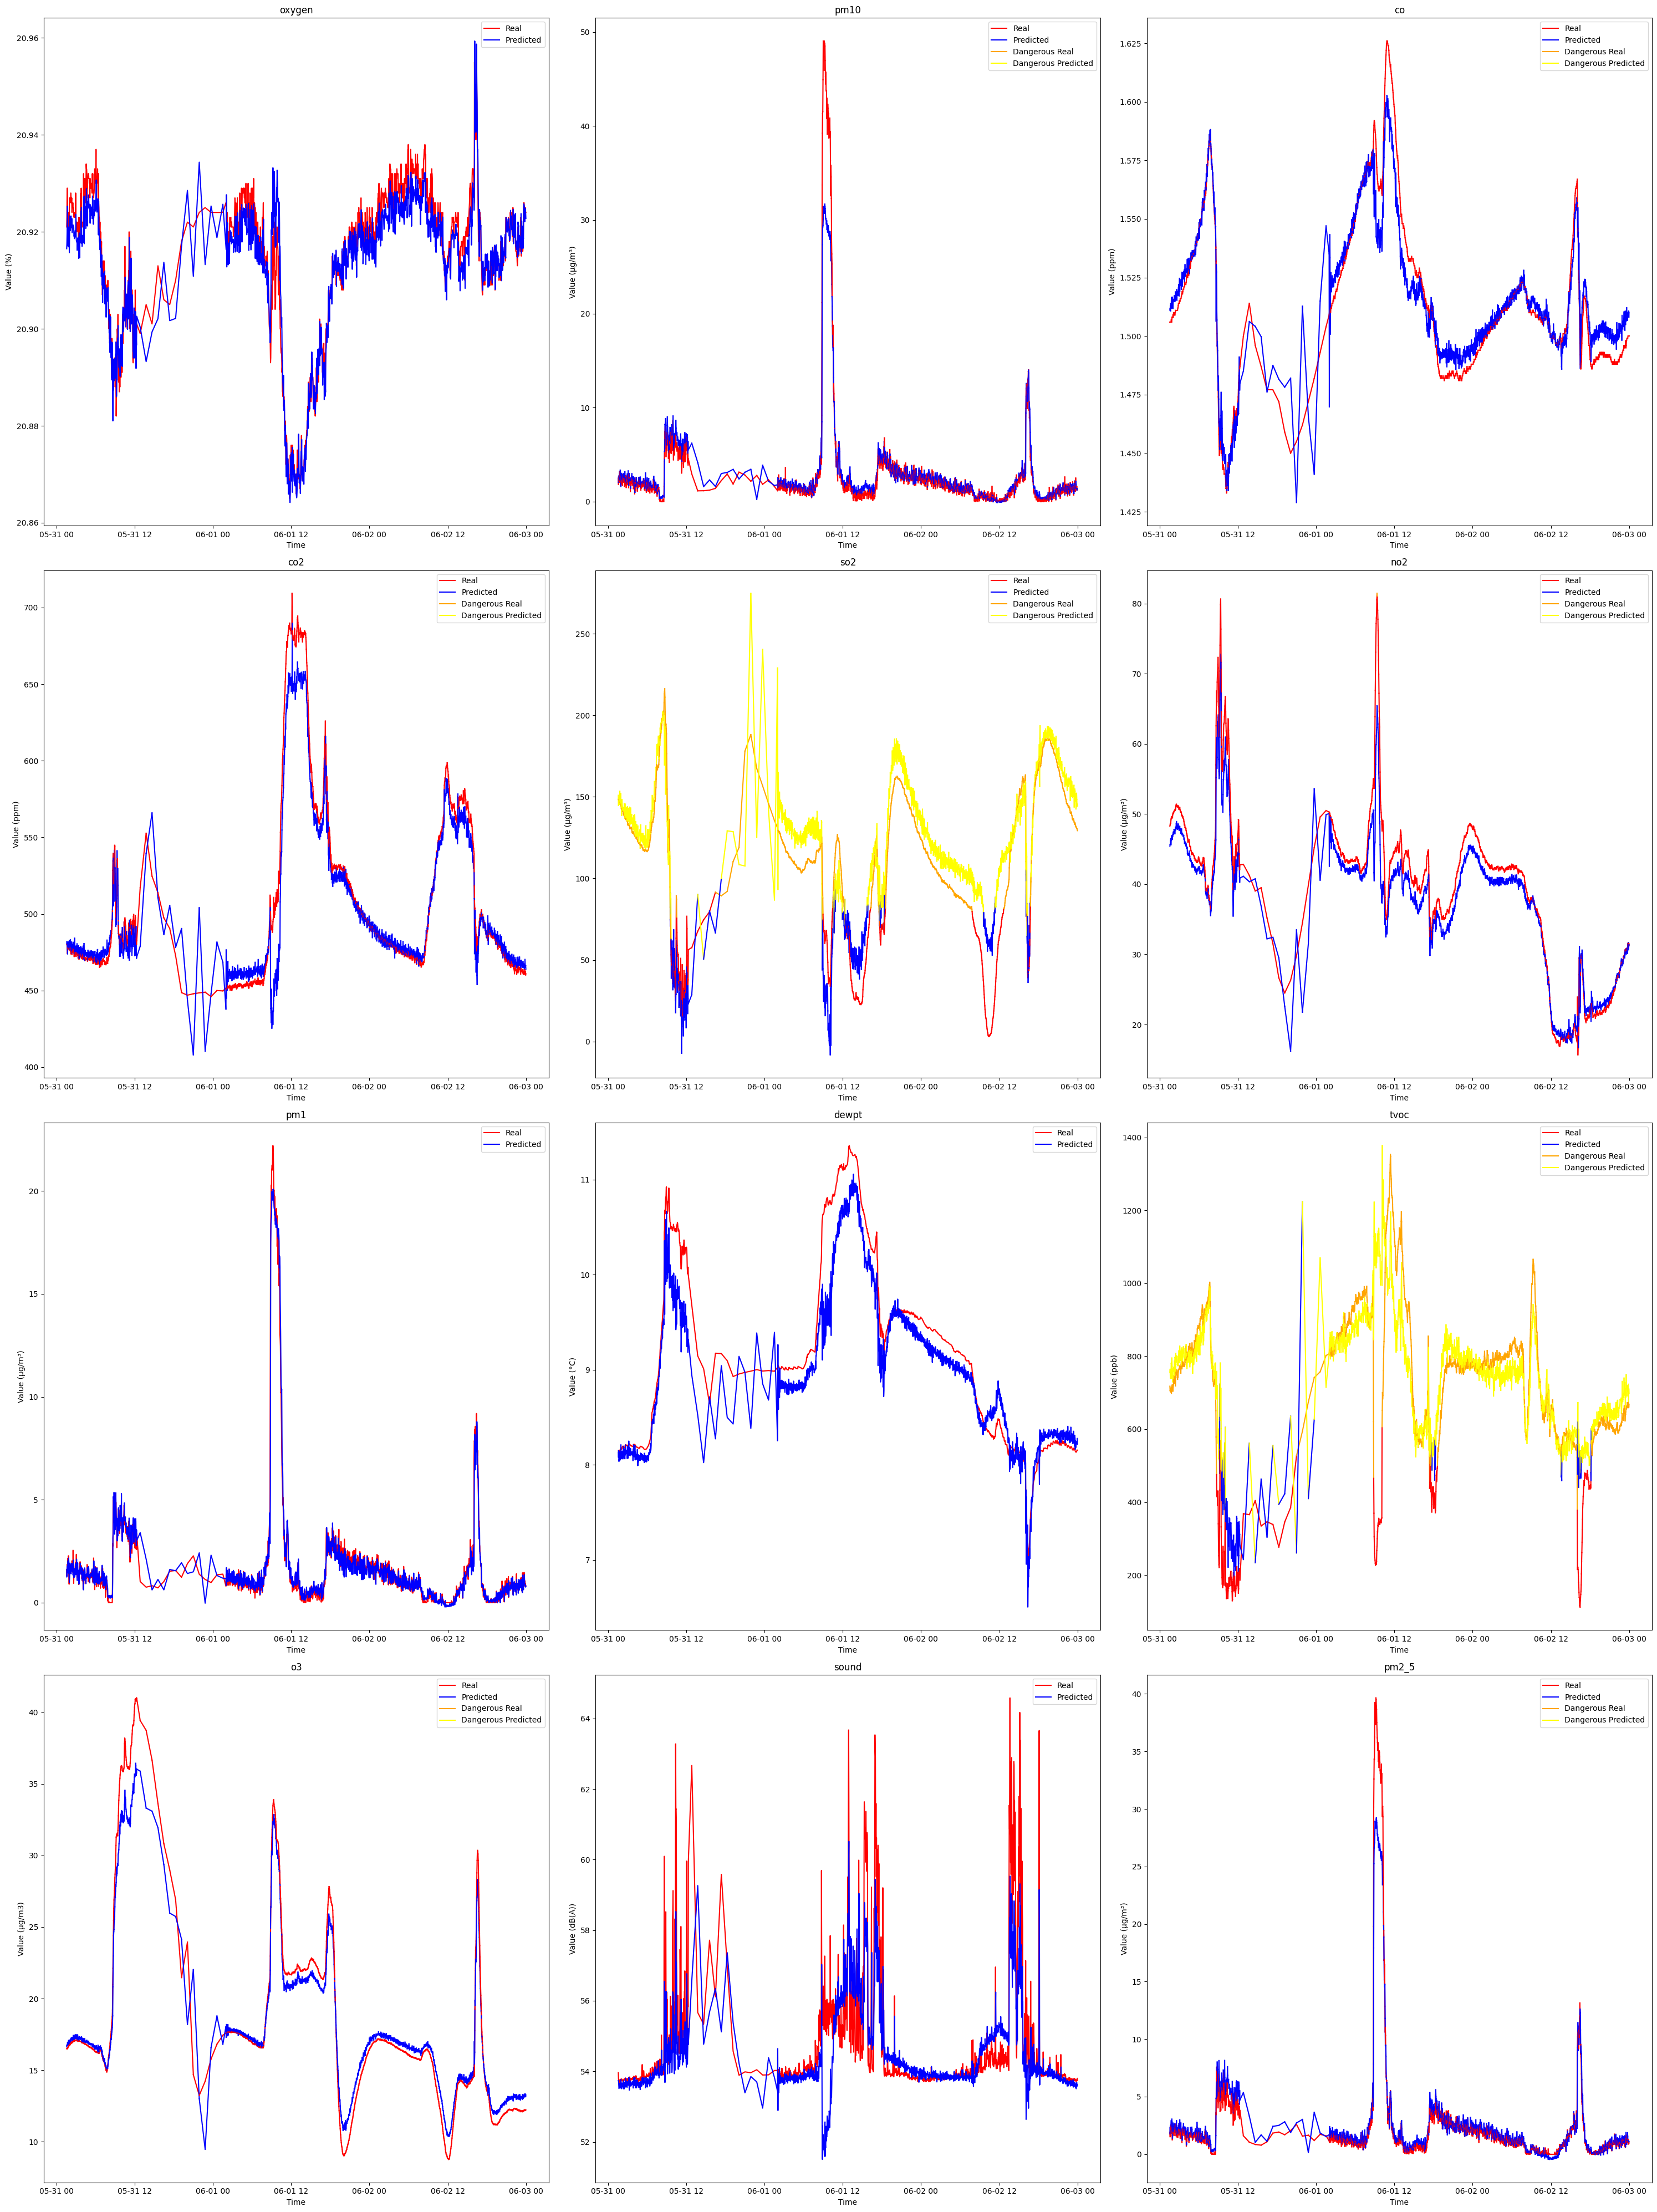

In [52]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'o3' : 9, 'sound': 10, 'pm2_5': 11
}

feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

In [53]:
selected_columns2 = [i for i in range(n_features) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
print(inv_y.shape, inv_yhat.shape)
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'o3', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

(1707, 12) (1707, 12)
Test RMSE for oxygen: 0.005
Test RMSE for pm10: 2.267
Test RMSE for co: 0.010
Test RMSE for co2: 14.314
Test RMSE for so2: 20.508
Test RMSE for no2: 3.254
Test RMSE for pm1: 0.511
Test RMSE for dewpt: 0.343
Test RMSE for tvoc: 154.045
Test RMSE for o3: 1.272
Test RMSE for sound: 1.227
Test RMSE for pm2_5: 1.481


In [54]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 11]
inv_y_PM25_values = inv_y[:, 11]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

In [55]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 1]
inv_y_PM10_values = inv_y[:, 1]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

In [56]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 4]
inv_y_SO2_values = inv_y[:, 4]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

In [57]:
## NO2 Sub-Index calculation
def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 5]
inv_y_NO2_values = inv_y[:, 5]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in inv_yhat_NO2_values]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in inv_y_NO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

In [58]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 2]
inv_y_CO_values = inv_y[:, 2]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in inv_yhat_CO_values]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in inv_y_CO_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

In [59]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 9]
inv_y_O3_values = inv_y[:, 9]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

In [60]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 12
PM10_SubIndex_col = 13
SO2_SubIndex_col = 14
NO2_SubIndex_col = 15
CO_SubIndex_col = 16
O3_SubIndex_col = 17

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

        col0      col1      col2        col3        col4       col5      col6  \
0  20.916515  2.010444  1.511584  480.709198  150.982346  45.418888  1.253802   
1  20.917650  2.598424  1.510978  481.857208  144.735962  45.648640  1.642042   
2  20.919815  2.065112  1.512933  481.182678  149.290833  45.742870  1.298311   
3  20.925287  2.725639  1.510783  476.979675  147.340759  46.143837  1.775110   
4  20.925007  2.628472  1.513775  473.954376  147.737305  46.478569  1.699483   

       col7        col8       col9  ...     col11     col12     col13  \
0  8.132335  755.745667  16.622492  ...  1.759472  2.932454  2.010444   
1  8.075648  764.217834  16.734829  ...  2.320054  3.866756  2.598424   
2  8.151133  740.539917  16.759995  ...  1.820513  3.034189  2.065112   
3  8.034680  755.496826  16.794691  ...  2.466018  4.110030  2.725639   
4  8.062128  746.810608  16.934996  ...  2.368147  3.946911  2.628472   

        col14      col15      col16      col17  AQI_calculated  Checks  \


In [61]:
rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
print("RMSE: " + str(rmse))

RMSE: 1.4812155132112577


In [62]:
from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.942589338019918


In [116]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 

1500.0


**Multivariate GRU Predictive Modeling**

In [74]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000000   0.189904   0.848387   0.149366   0.996458   0.431124   
2   0.005791   0.184298   0.840322   0.141075   0.996445   0.430600   
3   0.000000   0.210760   0.833871   0.139532   0.996406   0.434559   
4   0.023125   0.187009   0.829032   0.139468   0.996424   0.443796   
5   0.017342   0.167540   0.824193   0.140394   0.996436   0.453471   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...   var3(t)   var4(t)  \
1   0.290591   0.325957        0.0    0.684472  ...  0.840322  0.141075   
2   0.291717   0.321531        0.0    0.683219  ...  0.833871  0.139532   
3   0.300005   0.320755        0.0    0.681139  ...  0.829032  0.139468   
4   0.304959   0.320910        0.0    0.680407  ...  0.824193  0.140394   
5   0.263208   0.319124        0.0    0.677807  ...  0.817742  0.136453   

    var5(t)   var6(t)   var7(t)   var8(t)  var9(t)  var10(t)  var11(t)  \
1  0.996445  0.430600  0.291717  0.321531      0.0  0.683219  0.452520   
2  0.996406  0.434559  0.300005  0.320755      0.0  0.681139  0.463491   
3  0.996424  0.443796  0.304959  0.320910      0.0  0.680407  0.594671   
4  0.996436  0.453471  0.263208  0.319124      0.0  0.677807  0.628608   
5  0.996360  0.460178  0.288835  0.316950      0.0  0.675136  0.503492   

   var12(t)  
1  0.206875  
2  0.222687  
3  0.206572  
4  0.173711  
5  0.206244  

[5 rows x 27 columns]

In [75]:
n_temps = 1440
n_features = 15

reframed = series_to_supervised(scaled, n_temps, 1)

In [76]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head(10)

var1(t-1440)  var2(t-1440)  var3(t-1440)  var4(t-1440)  var5(t-1440)  \
1440      0.000000      0.189904      0.848387      0.149366      0.996458   
1441      0.005791      0.184298      0.840322      0.141075      0.996445   
1442      0.000000      0.210760      0.833871      0.139532      0.996406   
1443      0.023125      0.187009      0.829032      0.139468      0.996424   
1444      0.017342      0.167540      0.824193      0.140394      0.996436   
1445      0.052032      0.179446      0.817742      0.136453      0.996360   
1446      0.052032      0.165583      0.809677      0.129000      0.996343   
1447      0.063583      0.197468      0.801613      0.128302      0.996262   
1448      0.057808      0.198426      0.795161      0.133763      0.996079   
1449      0.098267      0.184787      0.791935      0.125911      0.996032   

      var6(t-1440)  var7(t-1440)  var8(t-1440)  var9(t-1440)  var10(t-1440)  \
1440      0.431124      0.290591      0.325957           0.0       0.684472   
1441      0.430600      0.291717      0.321531           0.0       0.683219   
1442      0.434559      0.300005      0.320755           0.0       0.681139   
1443      0.443796      0.304959      0.320910           0.0       0.680407   
1444      0.453471      0.263208      0.319124           0.0       0.677807   
1445      0.460178      0.288835      0.316950           0.0       0.675136   
1446      0.468756      0.288925      0.314232           0.0       0.670976   
1447      0.474767      0.309373      0.309341           0.0       0.665280   
1448      0.475073      0.326217      0.304760           0.0       0.660529   
1449      0.475311      0.317209      0.303440           0.0       0.658497   

      ...   var3(t)   var4(t)   var5(t)   var6(t)   var7(t)   var8(t)  \
1440  ...  0.500000  0.200811  0.139095  0.543295  0.000000  0.302586   
1441  ...  0.501613  0.205701  0.139844  0.546806  0.000000  0.303207   
1442  ...  0.501613  0.204943  0.140383  0.549420  0.000000  0.304061   
1443  ...  0.500000  0.204206  0.140742  0.548342  0.000000  0.304527   
1444  ...  0.500000  0.204129  0.140886  0.546090  0.000000  0.306390   
1445  ...  0.501613  0.200637  0.141140  0.544554  0.000000  0.305769   
1446  ...  0.500000  0.201898  0.141533  0.540957  0.000540  0.306623   
1447  ...  0.500000  0.206556  0.141671  0.538448  0.000045  0.307477   
1448  ...  0.501613  0.207845  0.142326  0.537160  0.000000  0.307633   
1449  ...  0.501613  0.211306  0.142816  0.538467  0.000000  0.307555   

       var9(t)  var10(t)  var11(t)  var12(t)  
1440  0.046314  0.420208  0.328529  0.000000  
1441  0.046773  0.420161  0.334833  0.000000  
1442  0.047219  0.418601  0.333231  0.000000  
1443  0.047363  0.417845  0.337047  0.000000  
1444  0.047463  0.417230  0.345940  0.000000  
1445  0.049822  0.418364  0.336911  0.000000  
1446  0.047779  0.418695  0.323963  0.000303  
1447  0.047324  0.420468  0.328188  0.000025  
1448  0.046930  0.421957  0.314150  0.000000  
1449  0.047382  0.422406  0.332039  0.000000  

[10 rows x 21612 columns]

In [77]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows * 0.9)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_temps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(28321, 21600) (28321, 12) (1707, 21600) (1707, 12)


In [78]:
train_X = train_X.reshape((train_X.shape[0], n_temps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_temps, n_features))

print(test_X.shape,train_X.shape)

(1707, 1440, 15) (28321, 1440, 15)


In [79]:
model = Sequential()
model.add(GRU(30, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

d:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 30)             │         4,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,602 (17.98 KB)

 Trainable params: 4,602 (17.98 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/100
222/222 - 116s - 521ms/step - loss: 0.1429 - val_loss: 0.0755
Epoch 2/100
222/222 - 113s - 511ms/step - loss: 0.0862 - val_loss: 0.0547
Epoch 3/100
222/222 - 118s - 532ms/step - loss: 0.0653 - val_loss: 0.0419
Epoch 4/100
222/222 - 116s - 521ms/step - loss: 0.0535 - val_loss: 0.0332
Epoch 5/100
222/222 - 121s - 543ms/step - loss: 0.0463 - val_loss: 0.0296
Epoch 6/100
222/222 - 121s - 545ms/step - loss: 0.0420 - val_loss: 0.0281
Epoch 7/100
222/222 - 121s - 545ms/step - loss: 0.0390 - val_loss: 0.0278
Epoch 8/100
222/222 - 115s - 519ms/step - loss: 0.0364 - val_loss: 0.0266
Epoch 9/100
222/222 - 112s - 503ms/step - loss: 0.0344 - val_loss: 0.0256
Epoch 10/100
222/222 - 115s - 520ms/step - loss: 0.0329 - val_loss: 0.0253
Epoch 11/100
222/222 - 118s - 530ms/step - loss: 0.0321 - val_loss: 0.0232
Epoch 12/100
222/222 - 111s - 500ms/step - loss: 0.0309 - val_loss: 0.0221
Epoch 13/100
222/222 - 113s - 509ms/step - loss: 0.0303 - val_loss: 0.0229
Epoch 14/100
222/222 - 115s - 516m

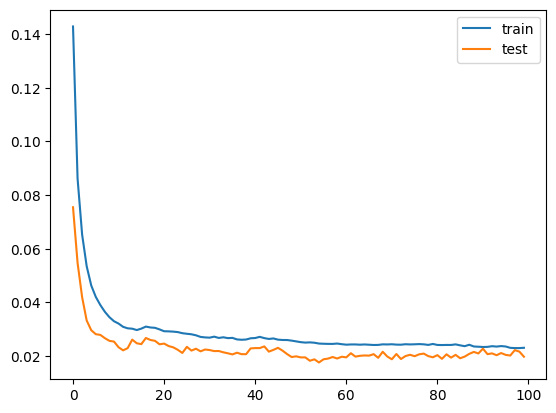

In [80]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[early_stopping])
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [81]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_temps*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [12, 13, 14]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns]

test_y = test_y.reshape(len(test_y), test_y.shape[1])
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())

54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step
          0      1      2           3           4          5      6      7   \
0  20.921000  2.475  1.506  479.887970  148.612000  48.271999  1.595  8.146   
1  20.923000  1.821  1.506  480.033997  148.227005  48.425999  1.291  8.151   
2  20.929001  2.565  1.506  478.789001  148.326004  48.632000  1.855  8.149   
3  20.929001  2.167  1.506  474.342010  148.130005  48.690002  1.599  8.143   
4  20.926001  2.737  1.506  475.026001  148.029999  48.692001  1.796  8.140   

           8          9          10     11  
0  717.888000  16.506001  53.962002  1.900  
1  705.403992  16.485001  53.779999  1.519  
2  704.439087  16.494999  53.749001  2.229  
3  710.427002  16.527998  53.685001  2.133  
4  701.901978  16.542997  53.720001  2.199  


In [82]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

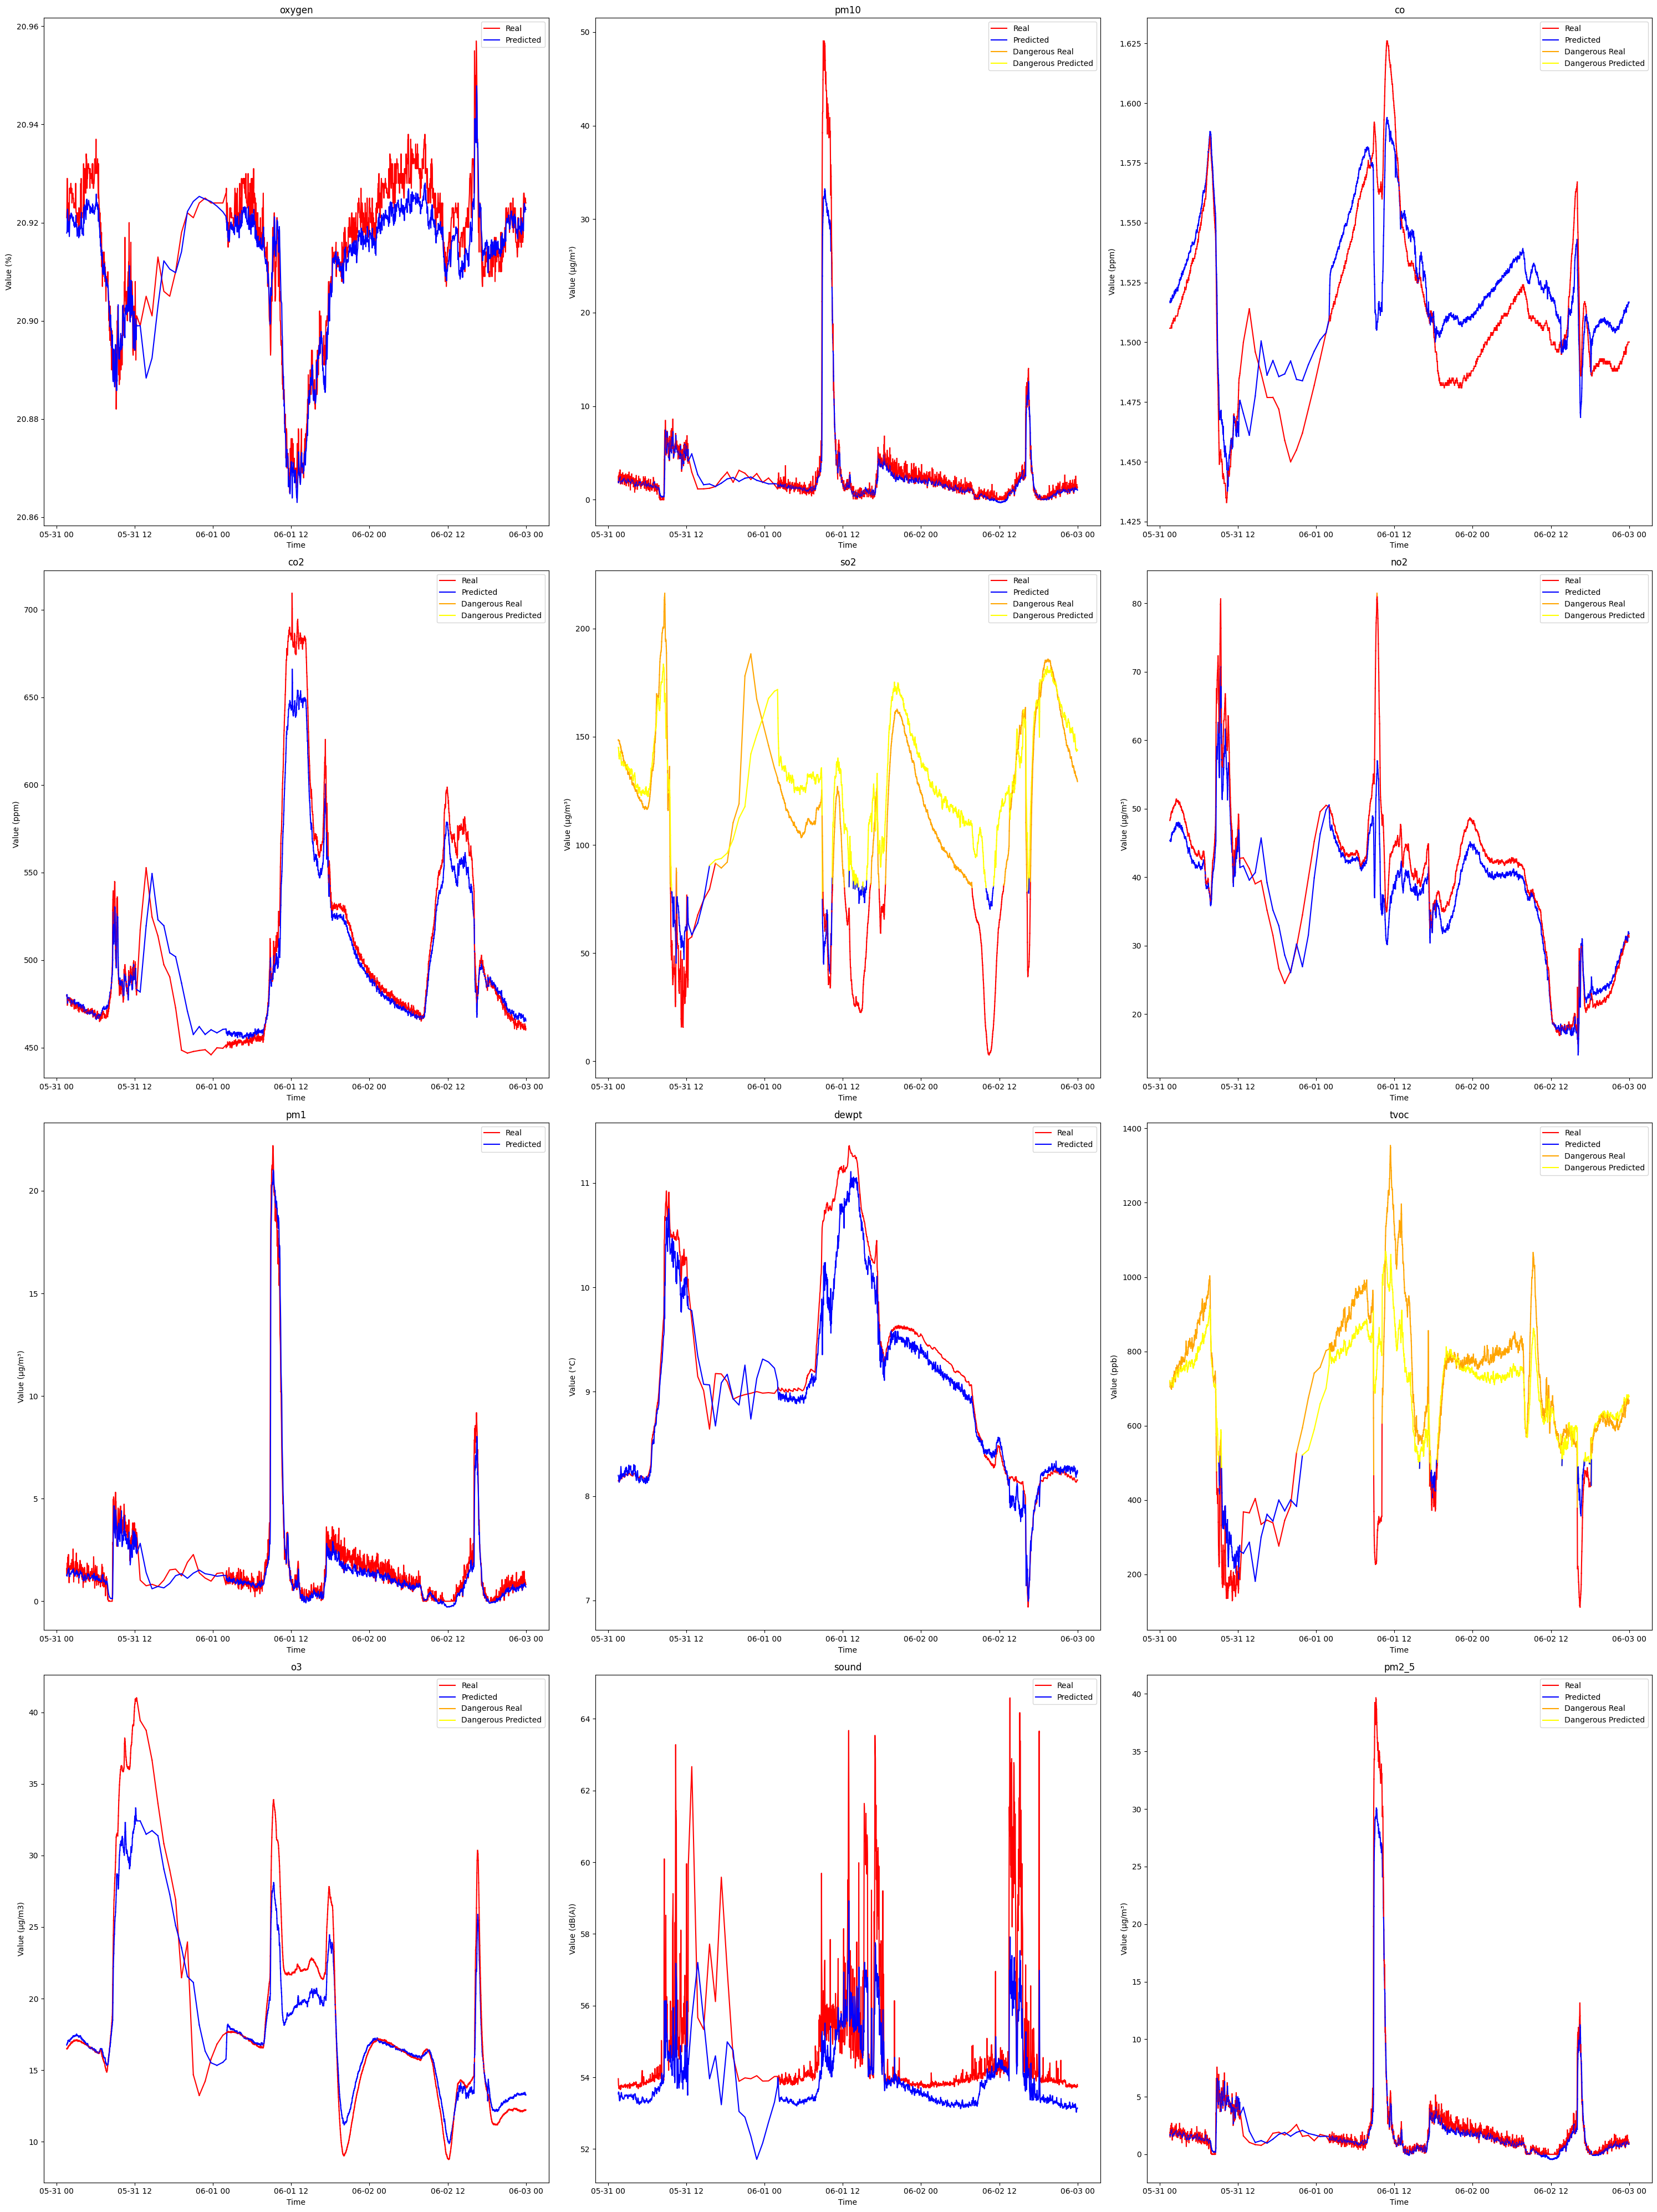

In [83]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'o3' : 9, 'sound': 10, 'pm2_5': 11
}

feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

In [84]:
selected_columns2 = [i for i in range(n_features) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
print(inv_y.shape, inv_yhat.shape)
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'o3', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

(1707, 12) (1707, 12)
Test RMSE for oxygen: 0.005
Test RMSE for pm10: 2.107
Test RMSE for co: 0.018
Test RMSE for co2: 13.144
Test RMSE for so2: 25.759
Test RMSE for no2: 4.108
Test RMSE for pm1: 0.614
Test RMSE for dewpt: 0.238
Test RMSE for tvoc: 117.089
Test RMSE for o3: 2.210
Test RMSE for sound: 1.366
Test RMSE for pm2_5: 1.396


In [85]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 11]
inv_y_PM25_values = inv_y[:, 11]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

In [86]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 1]
inv_y_PM10_values = inv_y[:, 1]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

In [87]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 4]
inv_y_SO2_values = inv_y[:, 4]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

In [88]:
## NO2 Sub-Index calculation
def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 5]
inv_y_NO2_values = inv_y[:, 5]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in inv_yhat_NO2_values]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in inv_y_NO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

In [89]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 2]
inv_y_CO_values = inv_y[:, 2]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in inv_yhat_CO_values]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in inv_y_CO_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

In [90]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 9]
inv_y_O3_values = inv_y[:, 9]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

In [91]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 12
PM10_SubIndex_col = 13
SO2_SubIndex_col = 14
NO2_SubIndex_col = 15
CO_SubIndex_col = 16
O3_SubIndex_col = 17

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

        col0      col1      col2        col3        col4       col5      col6  \
0  20.917883  1.871006  1.517174  479.427826  145.116821  45.367805  1.253512   
1  20.917978  1.933487  1.516607  480.237488  144.750748  45.328575  1.292911   
2  20.918434  1.833065  1.516595  480.077515  143.174149  45.250904  1.224364   
3  20.921829  1.965737  1.517007  478.129395  141.179550  45.405869  1.328115   
4  20.922743  1.991212  1.518350  475.474030  139.918472  45.583313  1.348439   

       col7        col8       col9  ...     col11     col12     col13  \
0  8.198130  721.658752  16.754616  ...  1.653088  2.755147  1.871006   
1  8.187755  715.838379  16.804705  ...  1.707736  2.846227  1.933487   
2  8.182270  711.956238  16.829382  ...  1.615710  2.692850  1.833065   
3  8.143575  708.828247  16.878912  ...  1.742814  2.904690  1.965737   
4  8.131887  712.740906  16.915365  ...  1.770181  2.950302  1.991212   

        col14      col15      col16      col17  AQI_calculated  Checks  \


In [92]:
rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
print("RMSE: " + str(rmse))

RMSE: 1.3955695655843945


In [93]:
from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.9238429994141769


In [137]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 

1536.0
